In [1]:
#Libraries and modules
import os
import pandas as pd
import numpy as np
import netCDF4 as nc
import xarray as xr
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from dotenv import load_dotenv
import earthaccess
import requests
from datetime import datetime, timedelta
from noaa_sdk import NOAA
import logging

from dotenv import load_dotenv
load_dotenv()

#DATA PATHS

CLIMATE_DATA_PATH = os.path.abspath("climate_data/")
BIRD_DATA_PATH = os.path.abspath("bird_data/")
FISH_DATA_PATH = os.path.abspath("fish_data/")
BIRD_DATA_FILE = os.path.join("bird_data", "gbif_bird_data.csv")

# Ensure directories exist
for path in [CLIMATE_DATA_PATH, BIRD_DATA_PATH, FISH_DATA_PATH]:
    os.makedirs(path, exist_ok=True)

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

Importing plotly failed. Interactive plots will not work.


In [2]:
#KEY LOADING

"""
#NASA EARTHACCESS
bearer_token = os.getenv("NASA_BEARER_TOKEN")
#gbif_api_key = os.getenv("GBIF_API_KEY")

if not bearer_token :
    raise ValueError("------- TOKEN NOT FOUND. - ERROR: NASA EARTHACCESS BEARER TOKEN.")
#if not gbif_api_key :
#    raise ValueError("------- TOKEN NOT FOUND. - ERROR: GBIF API KEY.")

'''
Turns out GBIF does not require an API key. Which is kind of dope. Less work for me
'''

auth = earthaccess.login(persist=True)

#Session Check
if not auth:
    raise RuntimeError("!------- AUTHENTICATION FAILED.")

datasets = earthaccess.search_data(short_name="MOD11A1", version="6.1")
print("------- AVAILABLE DATASETS: ", datasets)
"""
#NASA you failed me.

def load_climate_data():
    """Loads and cleans the new Global Land Temperature dataset."""
    try:
        climate_data_path = os.path.join(CLIMATE_DATA_PATH, "GlobalLandTemperaturesByMajorCity.csv")
        if not os.path.exists(climate_data_path):
            raise FileNotFoundError("------- Climate data CSV not found.")

        # Load CSV
        df = pd.read_csv(climate_data_path)

        # Convert dt column to datetime format
        df["dt"] = pd.to_datetime(df["dt"], errors="coerce")

        # Rename columns for consistency
        df.rename(columns={"dt": "timestamp", "AverageTemperature": "Temperature"}, inplace=True)

        # Drop missing temperature values
        df.dropna(subset=["Temperature"], inplace=True)

        # Select only relevant columns
        df = df[["timestamp", "Temperature"]]

        logging.info(f"------- Climate Data Loaded and Cleaned: {len(df)} records")
        return df
    except Exception as e:
        logging.error(f"------- Climate Data Load Error: {e}")
        return None

# Load & clean new climate data
climate_df = load_climate_data()



2025-02-07 13:40:46,390 - INFO - ------- Climate Data Loaded and Cleaned: 228175 records


In [10]:
#BIRD DATA FETCH & LOAD 

def fetch_bird_data():
    """Fetches bird migration data from the GBIF API with proper pagination and saves locally."""
    if os.path.exists(BIRD_DATA_FILE):
        logging.info("------- Loading Bird Data from Local File")
        return pd.read_csv(BIRD_DATA_FILE)

    logging.info("------- Fetching Bird Data from GBIF API with pagination")
    try:
        batch_size = 1000  # GBIF limit per request
        max_records = 50000  # Adjust as needed
        total_records = []
        offset = 0

        while len(total_records) < max_records:
            gbif_url = f"https://api.gbif.org/v1/occurrence/search?taxonKey=212&limit={batch_size}&offset={offset}&hasCoordinate=true"
            response = requests.get(gbif_url)

            if response.status_code != 200:
                logging.error(f"------- GBIF API Error: {response.status_code} - {response.text}")
                break  # Stop on failure

            data = response.json().get("results", [])
            if not data:
                logging.info("------- No more records found. Pagination complete.")
                break  # Stop if no more records

            total_records.extend(data)
            offset += batch_size  # Move to next batch

            logging.info(f"------- Fetched {len(total_records)} records so far...")

        if not total_records:
            logging.error("------- ERROR: No bird migration records retrieved.")
            return None

        df = pd.DataFrame(total_records)

        # Keep relevant columns
        df = df[["decimalLatitude", "decimalLongitude", "eventDate", "species"]]
        df.rename(columns={"decimalLatitude": "latitude", "decimalLongitude": "longitude", "eventDate": "timestamp"}, inplace=True)
        df.dropna(subset=["latitude", "longitude", "timestamp"], inplace=True)
        df.to_csv(BIRD_DATA_FILE, index=False)

        logging.info(f"------- Bird Migration Data Fetched and Saved: {len(df)} records")
        return df
    except Exception as e:
        logging.error(f"------- GBIF Bird Data Fetch Error: {e}")
        return None

    

# Fetch & clean bird data
bird_df = fetch_bird_data()

'''
GBIF_API_URL = "https://api.gbif.org/v1/species/match"
OCCURRENCE_API_URL = "https://api.gbif.org/v1/occurrence/search"

def get_gbif_taxon_key(species_name):
    """Fetches taxon serial ID for species by the species name."""
    response = requests.get(f"{GBIF_API_URL}?name={species_name}")
    if response.status_code = 200:
        data = response.json()
        return data.get("usageKey", None)
    return None

def fetch_gbif_data(species_name, limit=5000):
    """Fetches MIGRATION DATA based on the taxon key gained from previous func"""
    taxon_key = get_gbif_taxon_key(species_name)
    if not taxon_key:
        print(f"------- NO TAXON KEY FOUND FOR {species_name}")
        return None
    
    params = {
        "taxonKey" : taxon_key,
        "limit" : limit,
        "hasCoordinate" : True,
        "year" : "2000, 2024"
    }
    
    response = requests.get(OCCURRENCE_API_URL, params=params)
    if response.status_code == 200:
        data = response.json()
        if "results" not in data or len(data["results"]) == 0:
            print(f"------- No results found for {species_name}.")
            return None
        
        return pd.DataFrame([
            {
                "species": entry.get("species", ""),
                "latitude": entry.get("decimalLatitude", ""),
                "longitude": entry.get("decimalLongitude", ""),
                "timestamp": entry.get("eventDate", "")
            }
            for entry in data["results"]
        ])
    else:
        print(f"------- Error fetching GBIF data for {species_name}: {response.status_code}")
        return None

os.makedirs(BIRD_DATA_PATH, exist_ok=True)

# List of species to dynamically fetch
species_list = ["Barn Swallow", "Arctic Tern", "Whooping Crane"]
'''
"""  
1. Barn Swallow - Chosen for abundance of data
2. Arctic Tern - Chosen for distance of migration
3. Whooping Crane - Chosen for endangered status
"""
'''
for species in species_list:
    df = fetch_gbif_data(species)
    if df is not None:
        file_path = f"{BIRD_DATA_PATH}/{species.replace(' ', '_')}.csv"
        df.to_csv(file_path, index=False)
        print(f"------- Saved {species} data to {file_path}")

def load_migration_data(file_path):
    """Loads migration data from a CSV file."""
    df = pd.read_csv(file_path)
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
    return df

# Load bird data
bird_files = os.listdir(BIRD_DATA_PATH)
bird_df = load_migration_data(os.path.join(BIRD_DATA_PATH, bird_files[0])) if bird_files else None
'''



2025-02-07 13:48:01,245 - INFO - ------- Loading Bird Data from Local File


'\nfor species in species_list:\n    df = fetch_gbif_data(species)\n    if df is not None:\n        file_path = f"{BIRD_DATA_PATH}/{species.replace(\' \', \'_\')}.csv"\n        df.to_csv(file_path, index=False)\n        print(f"------- Saved {species} data to {file_path}")\n\ndef load_migration_data(file_path):\n    """Loads migration data from a CSV file."""\n    df = pd.read_csv(file_path)\n    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")\n    return df\n\n# Load bird data\nbird_files = os.listdir(BIRD_DATA_PATH)\nbird_df = load_migration_data(os.path.join(BIRD_DATA_PATH, bird_files[0])) if bird_files else None\n'

In [4]:
#FISH DATA FETCH & LOAD
'''
def fetch_fish_data():
    """Loads fishing vessel activity data from a local CSV file."""
    try:
        fish_data_path = os.path.join(FISH_DATA_PATH, "fish_migration_data.csv")
        if not os.path.exists(fish_data_path):
            raise FileNotFoundError("------- Fish data CSV not found. Please ensure the file is in the correct location.")
        df = pd.read_csv(fish_data_path)
        logging.info(f"------- Fish Migration Data Loaded: {len(df)} records")
        return df
    except Exception as e:
        logging.error(f"------- Fish Data Load Error: {e}")
        return None

# Fetch fish data
fish_df = fetch_fish_data()
'''

'\ndef fetch_fish_data():\n    """Loads fishing vessel activity data from a local CSV file."""\n    try:\n        fish_data_path = os.path.join(FISH_DATA_PATH, "fish_migration_data.csv")\n        if not os.path.exists(fish_data_path):\n            raise FileNotFoundError("------- Fish data CSV not found. Please ensure the file is in the correct location.")\n        df = pd.read_csv(fish_data_path)\n        logging.info(f"------- Fish Migration Data Loaded: {len(df)} records")\n        return df\n    except Exception as e:\n        logging.error(f"------- Fish Data Load Error: {e}")\n        return None\n\n# Fetch fish data\nfish_df = fetch_fish_data()\n'

In [12]:
#TRAIN TEST SPLITTING

def split_data(df, test_size=0.2):
    """Splits dataset into training and testing sets."""
    if df is not None and not df.empty:
        train_df, test_df = train_test_split(df, test_size=test_size, random_state=42)
        return train_df, test_df
    else:
        print("------- Data is empty or None. Skipping train-test split.")
        return None, None

def merge_climate_bird_data(bird_df, climate_df):
    """Merges bird migration data with climate data using closest available date."""
    if bird_df is None or climate_df is None:
        logging.error("------- One or more datasets are empty. Cannot merge.")
        return None

    # Convert timestamps
    bird_df["timestamp"] = pd.to_datetime(bird_df["timestamp"], errors='coerce')
    climate_df["timestamp"] = pd.to_datetime(climate_df["timestamp"], errors='coerce')

    # Remove rows where bird timestamps are missing (NaT)
    bird_df = bird_df.dropna(subset=["timestamp"])

    # Sort climate data by date
    climate_df = climate_df.sort_values(by="timestamp")

    # Merge using closest available climate record for each bird entry
    merged_df = pd.merge_asof(
        bird_df.sort_values("timestamp"),
        climate_df,
        on="timestamp",
        direction="backward"
    )

    # Debugging: Check if Temperature column exists
    if "Temperature" not in merged_df.columns or merged_df["Temperature"].isna().sum() == len(merged_df):
        logging.error("------- ERROR: 'Temperature' is still missing after merging. Investigate climate data alignment.")
        print(merged_df.head())  # Debugging step
        return None

    logging.info(f"------- Merged Bird & Climate Data: {len(merged_df)} records")
    return merged_df

print("Climate Data Columns:", climate_df.columns)

# Merge before training
merged_bird_df = merge_climate_bird_data(bird_df, climate_df)

if merged_bird_df is not None:
    print("Merged Bird Data Columns:", merged_bird_df.columns)

print("Merged Bird Data Sample (Post-Merge):")
print(merged_bird_df.head())

# Check how many rows have NaN Temperature
print(f"Missing Temperature Values in Merged Dataset: {merged_bird_df['Temperature'].isna().sum()}")


# Split Climate, Bird, and Marine data
train_climate_df, test_climate_df = split_data(climate_df)
train_bird_df, test_bird_df = train_test_split(bird_df, test_size=0.2, random_state=42)

print(f"Total Bird Data Records: {bird_df.shape}")
print(f"Unique Latitudes Before Cleaning: {bird_df['latitude'].nunique()}")
print(f"Unique Longitudes Before Cleaning: {bird_df['longitude'].nunique()}")

print(f"Train Shape: {train_bird_df.shape}")
print(f"Test Shape: {test_bird_df.shape}")
print(f"Unique Test Latitudes: {test_bird_df['latitude'].nunique()}")
print(f"Unique Test Longitudes: {test_bird_df['longitude'].nunique()}")

'''
# Split climate, bird, and fish data
train_climate_df, test_climate_df = split_data(climate_df) if climate_df is not None else (None, None)
train_bird_df, test_bird_df = split_data(bird_df) if bird_df is not None else (None, None)
#train_fish_df, test_fish_df = split_data(fish_df) if fish_df is not None else (None, None)
'''

2025-02-07 13:56:21,346 - INFO - ------- Merged Bird & Climate Data: 7 records


Climate Data Columns: Index(['timestamp', 'Temperature'], dtype='object')
Merged Bird Data Columns: Index(['latitude', 'longitude', 'timestamp', 'species', 'Temperature'], dtype='object')
Merged Bird Data Sample (Post-Merge):
    latitude   longitude           timestamp                  species  \
0 -22.711600  131.196336 2025-01-01 07:06:00     Lichmera indistincta   
1 -31.647571  152.594817 2025-01-01 18:23:00  Leucosarcia melanoleuca   
2 -22.774811  131.475797 2025-01-01 23:01:00      Petroica goodenovii   
3 -36.319735  146.832449 2025-01-04 21:09:00        Phaps chalcoptera   
4 -35.419427  149.939365 2025-01-07 05:05:00            Zanda funerea   

   Temperature  
0       14.281  
1       14.281  
2       14.281  
3       14.281  
4       14.281  
Missing Temperature Values in Merged Dataset: 0
Total Bird Data Records: (300, 4)
Unique Latitudes Before Cleaning: 204
Unique Longitudes Before Cleaning: 204
Train Shape: (5, 5)
Test Shape: (2, 5)
Unique Test Latitudes: 2
Unique Tes

'\n# Split climate, bird, and fish data\ntrain_climate_df, test_climate_df = split_data(climate_df) if climate_df is not None else (None, None)\ntrain_bird_df, test_bird_df = split_data(bird_df) if bird_df is not None else (None, None)\n#train_fish_df, test_fish_df = split_data(fish_df) if fish_df is not None else (None, None)\n'

In [13]:
#TRAINING MODELS

def evaluate_model(model, X_test, y_test, model_name):
    """Evaluates the model with multiple metrics."""
    if model is None:
        print(f"!------- {model_name} was not trained.")
        return None
    predictions = model.predict(X_test)
    r2 = r2_score(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    print(f"------- {model_name} Performance:")
    print(f"   R² Score: {r2:.4f}")
    print(f"   Mean Squared Error (MSE): {mse:.4f}")
    print(f"   Mean Absolute Error (MAE): {mae:.4f}")
    return predictions

# Linear Regression
def train_linear_regression(train_df, test_df):
    """Trains a Linear Regression model to predict migration patterns based on temperature."""
    if train_df is None or test_df is None:
        return None

    # Ensure Temperature column exists
    if "Temperature" not in train_df.columns:
        logging.error("------- ERROR: 'Temperature' column missing in dataset. Check merging step.")
        print(train_df.head())  # Debugging step
        return None

    # Print dataset stats before dropping NaNs
    print("Train Data (Before Handling NaNs):")
    print(train_df[["Temperature", "latitude"]].describe())

    print("Test Data (Before Handling NaNs):")
    print(test_df[["Temperature", "latitude"]].describe())

    # Option 1: Fill missing values with mean temperature
    train_df["Temperature"].fillna(train_df["Temperature"].mean(), inplace=True)
    test_df["Temperature"].fillna(test_df["Temperature"].mean(), inplace=True)

    # Option 2: Drop rows where Temperature OR latitude is NaN (if still necessary)
    train_df.dropna(subset=["Temperature", "latitude"], inplace=True)
    test_df.dropna(subset=["Temperature", "latitude"], inplace=True)

    # Check if data is empty after handling NaNs
    if train_df.empty or test_df.empty:
        logging.error("------- ERROR: No data left after handling NaNs. Investigate dataset.")
        return None

    # Features (X) = Temperature, Target (Y) = Latitude (Migration shift)
    X_train, X_test = train_df[["Temperature"]], test_df[["Temperature"]]
    y_train, y_test = train_df["latitude"], test_df["latitude"]

    # Train Model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predictions
    predictions = model.predict(X_test)

    logging.info(f"------- Linear Regression R^2 Score: {r2_score(y_test, predictions)}")
    return model, predictions



# Train Random Forest Model
def train_random_forest(train_df, test_df):
    if train_df is None or test_df is None:
        return None
    X_train, X_test = train_df[["Temperature"]], test_df[["Temperature"]]
    y_train, y_test = train_df["latitude"], test_df["latitude"]
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    predictions = evaluate_model(model, X_test, y_test, "Random Forest")
    return model, predictions

# Apply K-Means Clustering
def apply_kmeans(df, num_clusters=3):
    if df is None or df.empty:
        return None
    X = df[["latitude", "longitude"]]
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    df["cluster"] = kmeans.fit_predict(X)
    print("------- K-Means Clustering applied.")
    return df

# Train ARIMA Model
def train_arima(df):
    """Trains an ARIMA model for climate forecasting based on temperature trends."""
    if df is None or df.empty:
        logging.error("------- ERROR: Climate data is empty. Cannot train ARIMA.")
        return None

    # Ensure timestamp exists
    if "timestamp" not in df.columns:
        logging.error("------- ERROR: 'timestamp' column missing in climate data. Check data loading.")
        print(df.head())  # Debugging step
        return None

    # Convert timestamp to datetime and set it as index
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
    df = df.set_index("timestamp")["Temperature"]

    # Train ARIMA model
    model = ARIMA(df, order=(5,1,0))
    model_fit = model.fit()

    logging.info("------- ARIMA Model trained for climate forecasting.")
    return model_fit


# Train Prophet Model
def train_prophet(df):
    """Trains a Prophet model for temperature forecasting with optimized settings."""
    if df is None or df.empty:
        logging.error("------- ERROR: No data available for Prophet model.")
        return None

    df["ds"] = pd.to_datetime(df["timestamp"], errors="coerce")
    df["y"] = df["Temperature"]

    df.dropna(subset=["ds", "y"], inplace=True)

    df = df.sort_values("ds").tail(2000)

    try:
        model = Prophet()
        model.fit(df)

        future = model.make_future_dataframe(periods=365)  # 1-year forecast
        forecast = model.predict(future)

        logging.info("------- Prophet Model trained for long-term climate forecasting.")
        return model, forecast
    except Exception as e:
        logging.error(f"------- Prophet Training Error: {e}")
        return None, None


# Train models and get predictions
linear_reg_model, linear_predictions = train_linear_regression(train_bird_df, test_bird_df)
random_forest_model, rf_predictions = train_random_forest(train_bird_df, test_bird_df)
bird_clusters = apply_kmeans(train_bird_df)
arima_model = train_arima(train_climate_df)
prophet_model = train_prophet(train_climate_df)

C:\Users\SV\AppData\Local\Temp\ipykernel_24556\643654300.py:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df["Temperature"].fillna(train_df["Temperature"].mean(), inplace=True)
C:\Users\SV\AppData\Local\Temp\ipykernel_24556\643654300.py:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behav

Train Data (Before Handling NaNs):
       Temperature   latitude
count        5.000   5.000000
mean        14.281 -33.007904
std          0.000   5.737583
min         14.281 -36.319735
25%         14.281 -35.419427
50%         14.281 -35.335952
75%         14.281 -35.189597
max         14.281 -22.774811
Test Data (Before Handling NaNs):
       Temperature   latitude
count        2.000   2.000000
mean        14.281 -27.179586
std          0.000   6.318686
min         14.281 -31.647571
25%         14.281 -29.413578
50%         14.281 -27.179586
75%         14.281 -24.945593
max         14.281 -22.711600
------- Random Forest Performance:
   R² Score: -1.6499
   Mean Squared Error (MSE): 52.8997
   Mean Absolute Error (MAE): 5.7391
------- K-Means Clustering applied.


c:\Users\SV\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\SV\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\SV\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\SV\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and 

2025-02-07 13:58:15,606 - INFO - ------- Migration map generated successfully.


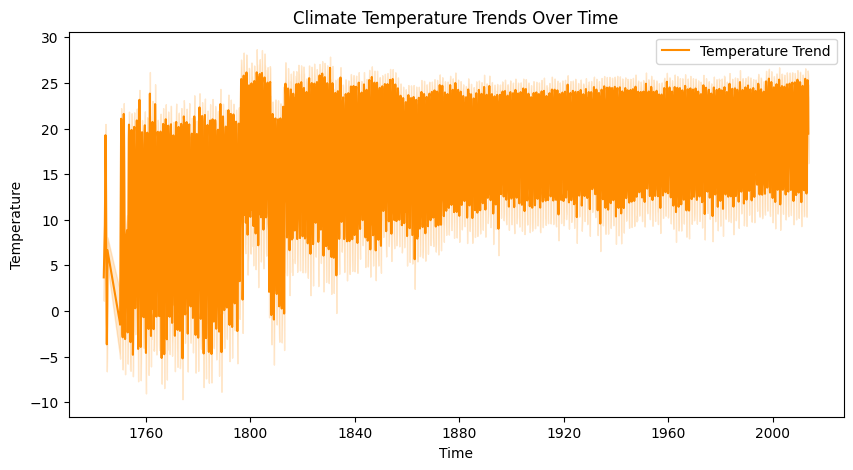

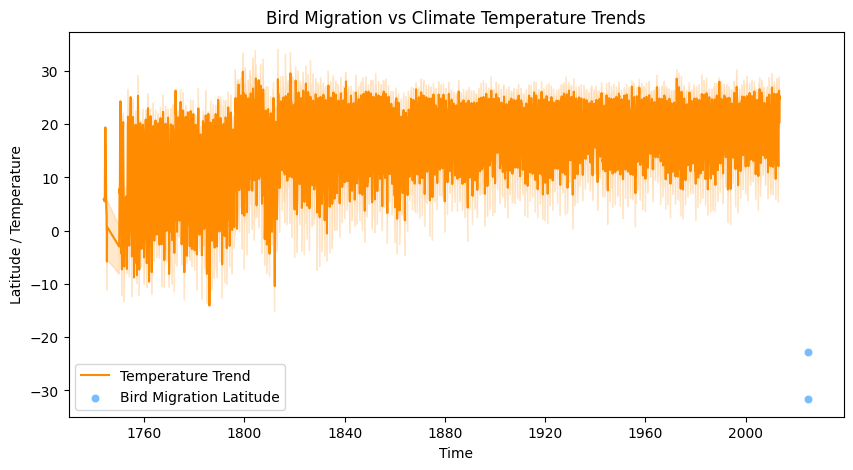

ValueError: n_samples=2 should be >= n_clusters=3.

In [14]:
#PLOTTING AND VISUALIZATION

import geopandas as gpd
import folium
import matplotlib.pyplot as plt
import seaborn as sns

def plot_predictions(actual, predicted, title):
    """Plots actual vs predicted values for regression models."""
    if actual is None or predicted is None or len(actual) == 0 or len(predicted) == 0:
        logging.error(f"------- ERROR: No valid data to plot for {title}.")
        return

    plt.figure(figsize=(8, 5))
    plt.scatter(actual, predicted, label="Predictions", color="dodgerblue")
    plt.plot(actual, actual, color="red", label="Ideal Fit")  # Ideal line y=x
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(title)
    plt.legend()
    plt.show()


def plot_temperature_trends(df):
    """Plots climate temperature trends over time."""
    if df is None or df.empty:
        logging.error("------- ERROR: No data available for temperature trends plot.")
        return

    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")

    plt.figure(figsize=(10, 5))
    sns.lineplot(x=df["timestamp"], y=df["Temperature"], label="Temperature Trend", color="darkorange")
    plt.xlabel("Time")
    plt.ylabel("Temperature")
    plt.title("Climate Temperature Trends Over Time")
    plt.legend()
    plt.show()


def plot_migration_map(df, title):
    """Plots migration patterns on a map and handles missing data issues."""
    if df is None or df.empty:
        logging.error("------- ERROR: No data available for migration map plot.")
        print("Bird DataFrame is empty or missing!")
        return None  # Return None explicitly

    required_columns = ["latitude", "longitude", "timestamp"]
    if not all(col in df.columns for col in required_columns):
        logging.error("------- ERROR: Required columns missing in migration dataset.")
        print(f"Columns Found: {df.columns}")  # Print existing columns
        return None  # Return None explicitly

    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
    
    migration_map = folium.Map(location=[df["latitude"].mean(), df["longitude"].mean()], zoom_start=3)

    for _, row in gdf.iterrows():
        folium.Marker([row["latitude"], row["longitude"]], popup=str(row["timestamp"])).add_to(migration_map)

    logging.info("------- Migration map generated successfully.")
    return migration_map


def plot_bird_vs_temperature(bird_df, climate_df):
    """Plots bird latitude shifts alongside temperature trends."""
    if bird_df is None or climate_df is None or bird_df.empty or climate_df.empty:
        logging.error("------- ERROR: No valid data to plot.")
        return

    bird_df["timestamp"] = pd.to_datetime(bird_df["timestamp"], errors="coerce")
    climate_df["timestamp"] = pd.to_datetime(climate_df["timestamp"], errors="coerce")

    plt.figure(figsize=(10, 5))
    sns.lineplot(x=climate_df["timestamp"], y=climate_df["Temperature"], label="Temperature Trend", color="darkorange")
    sns.scatterplot(x=bird_df["timestamp"], y=bird_df["latitude"], label="Bird Migration Latitude", color="dodgerblue", alpha=0.6)
    plt.xlabel("Time")
    plt.ylabel("Latitude / Temperature")
    plt.title("Bird Migration vs Climate Temperature Trends")
    plt.legend()
    plt.show()


def apply_kmeans(df, n_clusters=3):
    """Applies K-Means clustering to migration data."""
    if df is None or df.empty:
        logging.error("------- ERROR: No valid data for K-Means clustering.")
        return None

    df.dropna(subset=["latitude", "longitude"], inplace=True)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    df["cluster"] = kmeans.fit_predict(df[["latitude", "longitude"]])
    return df["cluster"]


def plot_kmeans_clusters(df, clusters, title="Migration Clusters"):
    """Plots K-Means clustering results."""
    if df is None or df.empty or clusters is None:
        logging.error("------- ERROR: No valid data to plot for K-Means clustering.")
        return

    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=df["longitude"], y=df["latitude"], hue=clusters, palette="viridis", alpha=0.7)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(title)
    plt.legend(title="Cluster")
    plt.show()

bird_migration_map = plot_migration_map(bird_df, "Bird Migration Map")
if bird_migration_map:
    bird_migration_map.save("bird_migration_map.html")
else:
    logging.error("------- ERROR: Migration map could not be saved because it was not generated.")

plot_temperature_trends(train_climate_df)
plot_bird_vs_temperature(test_bird_df, test_climate_df)

bird_clusters = apply_kmeans(test_bird_df)
plot_kmeans_clusters(test_bird_df, bird_clusters)

def plot_temperature_on_own(df):
    """Plots standalone temperature trends."""
    if df is None or df.empty:
        logging.error("------- ERROR: No data available for standalone temperature plot.")
        return

    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")

    plt.figure(figsize=(10, 5))
    sns.lineplot(x=df["timestamp"], y=df["Temperature"], color="blue")
    plt.xlabel("Time")
    plt.ylabel("Temperature")
    plt.title("Standalone Temperature Trends")
    plt.show()

plot_temperature_on_own(train_climate_df)
